In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd
import numpy as np
import json
import requests
from ratelimiter import RateLimiter
import plotly.express as px
import matplotlib.pyplot as plt
import contextily as cx
import time
from datetime import datetime
from IPython.display import clear_output
from IPython.display import JSON

# Foursquare API Venue Scrape
## Objective
This notebook will use the **Foursquare API** to find all venues in a geographic area and gather extended information (popularity, type, contact details, location etc.) for each venue:
- The Geographic area will be square shaped and defined using latitude and longitude coordinates. 
- The **Place Search** Foursquare API will be used to find the venues. 
- You can define the type of venue you want to find e.g. you could look for only bars and restaurants. 
- The **Get Place Details** Foursquare API will be used to get extended data on each venue. 

The end result will be a csv file containing all venues found and their associated data. The total cost of the API calls for a big city is ~\\$80 and thus the free tier Sandbox membership (\\$200 of free API calls per month) comfortably covers the costs.  

## Approach
Our code has 2 main sections: 
- **Venue Search** - Exhaustively search geographic area for venues. 
- **Get Venue Details** - Get extended venue information on each venue we found. 

In this section we provide a high level overview of how the **venue search** works. 

### Define Search Area
We define the search area using maximum and minimum latitude and longitude values. The intersection of these lines of latitude and longitude define a square area projected onto the Earth. Example latitude and longitude boundaries for London are shown below: 
- **minimum latitude** = 51.438499 
- **maximum latitude** = 51.546890
- **minimum longitude** = -0.240612
- **maximum longitude** = 0.026043

Below we visualise the geographic area defined by these coordinates: 


![alt text](images/geo_area.png)

### Project Search Area to Flat
The Search Area was defined by latitude and longitude. Latitude and longitude is a good coordinate system to define a location on the surface of the Earth. However, because they express location via angles, it is relatively difficult and slow to use latitude and longitude to define and calculate distances and areas. Our exhaustive venue search method relies heavily on distance and area calculations. As such, we will project our latitude longitude search area to a flat coordinate system. This system will define locations via a linear x and y coordinate system that is measured in meters. Distances and areas are much easier to calculate using this type of coordinate system. We chose to use the [ESRI:102013](https://epsg.io/102013) projection, which is calibrated for Europe and is an equal area projection. The projection step is the equivalent of converting a 3D globe of the Earth to a flat map representation. This warps the shapes of areas, and in our case appears to tilt the search area slightly. 

![alt text](images/projection.png) 


### Finding Venues with Foursquare
We will find venues within the search area using a Foursquare API call. This API accepts a location (defined by latitude and longitude) and a radius. Using these, the API will return a maximum of 50 venues that are within the provided radius of the provided location. If 50 venues are returned, then they will not be the 50 closest venues to the search location. They will instead be venues from across the whole radius. Thus, some venues within the radius will not be returned. To avoid missing these venues, we must reduce the radius provided to the API such that less than 50 venues are returned. At this point, the venues returned will be the closest venues to the search location and no venues will be missed.

### Search Process
We want to perform the API call at different locations around the search area until the entire area has been searched and all venues within it have been found. We will use the search area as our tracker of what locations need to be searched. Initially, the entire search area needs to be searched. We can select a random search location within the search area and perform the API call here. If 50 venues are returned, we'll reduce the search radius and repeat the API call until we get fewer than 50. At this point, we will have successfully searched a single circular area around the search location. We will track this by removing this circular area from the search area (a hole is created in the search area at the search location).  

![alt text](images/basic_search.png)

We repeat this process of searching for venues with the API and removing a circular area according to the location and radius used in the API call. The circles will be of different radii, depending on how small a radius was required in the API call to get fewer than 50 venues returned. Once we have erased the entire search area, then we will have searched the entire search area i.e. every single part of the search area was covered by an API call. At this point, we should have found all venues within the search area.  

![alt text](images/searching.gif)

### Multi-Search
We found that searching the entire search area using the above process does not actually return every single venue. It returns the vast **majority of venues (~90%)** but the specific venues returned are not consistent. On one run, it may return about 6400 venues and on a subsequent run it might return 6450 venues. By comparing the specific venues returned, we may find that the first run found 50 venues that the second run did not and the second run finds 100 venues that the first run did not. 

We investigated the issue and tried various tweaks and fixes but ultimately could not ascertain the cause of this inconsistency. We suspect it may be a problem with the Foursquare API itself i.e. it may not be returning certain venues on certain runs. Regardless, we found that the most effective solution to the problem was to re-run the entire search several times until no new venues were being found. We call this functionality  **multi-search** and it can be toggled on or off depending on your needs.

The multi-search typically finds a decreasing number of new venues on each subsequent run. We interpret this to mean we are probably approaching the point where all possible venues have been found (although we cannot prove this definitively). 

The benefit of multi-search is that it finds the last ~10% of venues that may have been missed on a single search. The drawback is that it significantly increases the number of API calls required and time to perform the search. 

### Initial Search Radius
We repeat the API call if 50 venues are returned, reducing the radius in each subsequent call. We call the first radius tested in this process the **Initial Search Radius**.

The density of venues varies significantly in different regions of the search area. There are large areas with few venues and small areas with many venues. Thus, the search is fastest if we can remove large areas of points on the grid where there is a low density of venues in a single API call. As a result, we will quickly remove a large number of low density points from the grid. This means the points remaining in the grid are more likely to be high density points requiring a small search radius. This in turn means that as the venue search progresses, the initial search radius will become more and more likely to be too large and thus be a wasted API call. 

To optimise the process, we count the fraction of searches every 20 seconds that required a smaller radius than the initial search radius we are using. When this value goes over 60% (i.e. 60% of locations searched in last 20 seconds need a smaller radius), we reduce the initial search radius used by 20%. This ensures we always have relatively large areas being removed in a single search and are not performing lots of small radius API calls. 

## Venue Search Functions
In this section, we will build the functions required to perform the venue search. 
### Load API Key
To use the Foursquare API you need a developer account and an API key that links to the account. We store this key as a plain text file called **key.txt**. It must be stored in the same directory as this notebook. Below we load the key from key.txt into our environment.   

In [9]:
# Import the foursquare key from text file (to keep key hidden on github)
with open('key.txt') as f:
    key = f.read()

### Define Place Search API Call
We will find venues using the [Place Search](https://developer.foursquare.com/reference/place-search) API. Below we define a function that takes a latitude and longitude coordinate and a search radius and then makes a [Place Search](https://developer.foursquare.com/reference/place-search) API call using them. The response will contain up to 50 venues found within the radius.  

The foursquare API has a rate limit of 50 calls per second. We used the **ratelimiter** package to apply this rate limit to the function. 

The following API Paramaters were used to define the API call: 
- **ll** - comma seperated latitude and longitude value e.g. '5123,0.0324'
- **radius** - the radius (in meters) around the latitude / longitude value that will be included in the search.
- **categories** - commas separated list of category codes. The search will only return businesses within those categories. The categories can be found [here](https://developer.foursquare.com/docs/categories). We primarily searched for bars alongside some other categories. You can leave this blank to return all businesses within the search area. 
- **sort** - defines how to sort results. We sorted by distance i.e. closest to the latitude / longitude value first. 
- **limit** - maximum number of results returned. 50 is the max number Foursquare allows. 

In [3]:
# Base url string of the Place Search API call
search_url = "https://api.foursquare.com/v3/places/search"

# RateLimiter decorator, ensures the api_call function is called less 
# than 50 times per second, the Foursquare rate limit
@RateLimiter(max_calls=49, period=1)
def api_call(long_lat, radius, cats, key):
    """Perform a foursquare places api search and return response.
    
    Args:
        long_lat (string): The latitude and longitude coordinate of 
            the search in comma separated format e.g. '51.513882,-0.119478'. 
            The API will find venues within a radius of this point.   
        radius (string): The search radius (in meters) for the venue 
            search e.g. '800'. 
        cats (string): A comma separated list of Foursquare Category Codes
            e.g. '11131,11039'. The search will only return venues in these 
            categories. Leave as empty list e.g. '' if you want all categories 
            included in search. 
        key (string): Foursquare API key. 

    Returns:
        api response: Response from foursquare places api call. The call was
            defined by the latitude and longitude, radius and categories supplied
            to the function. A maximum of 50 venues will be contained in the response.
    """
    
    # Defines paramaters to add to the search_url. These define the Search.  
    params = dict(ll = long_lat,
                  radius = radius, 
                  categories = cats,
                  sort = 'DISTANCE',
                  limit = '50'
                 )
    # Defines headers required in Place Search API call
    headers = {
        "Accept": "application/json",
        "Authorization": key
    }

    return requests.request("GET", search_url, headers = headers, params = params)

Below we perform a test Place Search API call to check it works as expected. It should return a JSON file containing a list of results. 

In [4]:
# Perform Place Search API call
response = api_call('51.513882,-0.119478', '1000', '11131,11039', key)
# extract results from response as json file
results = json.loads(response.text)
# Visualise results
JSON(results)

<IPython.core.display.JSON object>

### Extract Data From Foursquare Response
The Place Search API returns a response that contains a list of up to 50 venues. We want to extract the venue data (name, location etc.) of each venue. To do this we do the following:
- Extract text from API response and convert to JSON file 
- Filter the JSON on 'results' - this gives us a list of the up to 50 venues, where each element in the list is a dictionary containing the data for one venue. 
- Pass the list of venue data to the *extract_venues* function, this extracts the data from each element of the list and returns the data as a list of lists (in a format that can be readily converted to a pandas dataframe). 

The extract_venues function is defined below: 

In [5]:
def extract_venues(venues_list):
    """Extracts desired data from venue_list and returns as list of lists
    
    Args:
        venue_list (list): List of dictionaries, each dictionary contains the data
        of a venue. 
    
    Returns: 
        list: List of lists containing the desired venue data for all venues. 
    """
    venues = []
    # Loop through venue_list, each element is a nested dictionary containing 
    # data for a venue
    for venue in venues_list:
        # Foursquare ID, unique reference for the venue
        fsq_id = venue['fsq_id']
        latitude = venue['geocodes']['main']['latitude']
        longitude = venue['geocodes']['main']['longitude']
        venue_name = venue['name']
        # address and postcode data not always present, so use error handling
        try: 
            venue_address = venue['location']['address']
        except KeyError:
            venue_address = ''
        try:
            venue_postcode = venue['location']['postcode']
        except KeyError:
            venue_postcode = ''
            
        venues.append([fsq_id, venue_name, latitude, longitude, 
                       venue_address, venue_postcode])
    return venues

### Visualise and Project Search Area
It is useful to visualise the search area (such that you can understand exactly what is included in your geographic area and can tweak as required). We created the plot_search_area function to use plotly to visualise the search area (in geographic coordinates i.e. latitude and longitude coordinates). The plot is interactive, allowing you to zoom in and out. 

We also created a function to project the search area from latitude longitude coordinates to a flat coordinate system. If you wish to alter the flat projection used, you can simply change the value provided to the 'projection' argument when this function is called in the **search_area** function (defined later). 

Both functions are defined below:  

In [6]:
def plot_search_area(min_lat, max_lat, min_long, max_long):
    """Plot search area (in geographic coordinates)
    
    Args: 
        max_lat (float): maximum latitude of search area. 
        min_lat(float): minimum latitude of search area. 
        max_long (float): maximum longitude of search area. 
        min_long (float): minimum longitude of search area.
    
    Returns:
        (NA): Does not return anything. Creates and displays search
            area using Plotly. 
    """
    # Trace out search area perimeter, starting and ending on top left 
    # corner (max lat and min long)
    search_boundaries = [[max_lat, min_long],[max_lat, max_long], 
                         [min_lat, max_long], [min_lat,min_long], 
                         [max_lat, min_long]]
    # Convert to Dataframe
    df_boundaries = pd.DataFrame(search_boundaries, 
                                 columns = ['latitude', 'longitude'])

    # Plot as square area on a map
    fig = px.line_mapbox(df_boundaries, lat="latitude", lon="longitude", zoom = 9)
    fig.update_layout(mapbox_style="open-street-map", mapbox_zoom = 9, 
                      margin = {"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(autosize = False, width = 800, height = 300,)
    fig.show()

def project_search_area(max_lat, min_lat, max_long, min_long, projection):
    """Create search area and project to flat coordinate system. 
    
    Args: 
        max_lat (float): maximum latitude of search area. 
        min_lat(float): minimum latitude of search area. 
        max_long (float): maximum longitude of search area. 
        min_long (float): minimum longitude of search area. 
        projection (string): Name of coordinate reference system the search 
            area will be projected to e.g. 'ESRI:102013'. Will accept anything 
            that would be accepted by the geopandas .to_crs() function.
    
    Returns: 
        (Geopandas DataFrame): A dataframe with a single row that defines the 
            search area in projected coordinates. 
    """
    # We need to represent the search area coordinates in a geopandas dataframe. 
    # First we need to build a polygon to represent the area: 
    lats_of_search_area = [max_lat, max_lat, min_lat, min_lat, max_lat]
    longs_of_search_area = [min_long, max_long, max_long,min_long, min_long]
    # Convert max and min lat and long values to a polygon
    search_area_polygon = Polygon(zip(longs_of_search_area, 
                                      lats_of_search_area))
    # Now we turn the polygon to a geopandas dataframe
    search_area_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326',
                                       geometry=[search_area_polygon])  
    # project to flat coordinate system and return
    return search_area_gdf.to_crs(projection)

### Search For Venues
The **search_area** function performs the Place Search API call across the entire search area until every part of it has been covered by an API call i.e. every part has been searched for venues. With each API call, it will update the remaining search area (by removing a circular area from it that is representative of the last API call). It will periodically print the remaining search area to screen, allowing you to track the progress of the search. When the entire area is searched, it returns a list of lists detailing all venues found.

**Note** - if you wish to change the projection used to convert the latitude longitude area to flat projected coordinates, you must change the projection argument used to define the search area i.e. change the final argument of the **project_search_area()** function in the below line (by default it is 'ESRI:102013'): 
```
search_area = project_search_area(max_lat, min_lat, max_long, min_long, 'ESRI:102013')
```
The following functions are used by the **search_area** function: 
- **get_search_location** - Finds a random location within the remaining search area and returns this location in latitude and longitude coordinates (required for the API call) and in the flat coordinates (required to remove the circular area from the search area). 
- **update_search_area** - Removes the provided circular search area from the remaining search area. 

In [7]:
def get_search_location(search_area):
    """Return search location and its latitude longitude coordinate.
    
    Args: 
        search_area (Geopandas DataFrame): A single row dataframe showing the 
        remaining search area. 
    Returns: 
        (tuple): The next search location, defined in projected coordinates as
            a Geopandas Series, and its Comma separated latitude longitude 
            coordinate i.e. (search_location, lat_long). 
    """
    # Get next search location using representative_point() function (finds 
    # single point within the search area). 
    search_location = search_area.representative_point()
    # Convert location to lat long coordinate system
    search_location_lat_long = search_location.to_crs('epsg:4326')
    # Extract latitude and longitude
    latitude = search_location_lat_long.y.values[0]
    longitude = search_location_lat_long.x.values[0]
    # convert to string format 'latitude,longitude'. Note that we forced the 
    # longitude to show up to 20 decimal places to avoid the output being 
    # displayed in scientific notation which breaks the API call. 
    lat_long = f"{latitude},{longitude :.20f}"
    
    return (search_location, lat_long)

def update_search_area(search_area, area_just_searched):
    """Remove the area_just_searched from search_area"""
    return search_area.overlay(area_just_searched, how="difference")

def search_area(search_area_coords, initial_search_radius, cats, 
                time_between_updates, search_no):
    """Exhaustively Search area for venues using the Foursquare API. 
    
    Args: 
        search_area_coords (list): The max and min latitude and longitude 
            coordinates that define the search area. Must be in 
            form: [min_lat, max_lat, min_long, max_long] 
        initial_search_radius (int): The radius used in the first Foursquare 
            API call at each search location. If the search returns 50 results,
            the API call is repeated using a reduced radius.  
        cats (string): Comma seperated list of Foursquare venue category 
            codes e.g. '11131,11039'
        time_between_updates (int): Seconds between progress updates being output.
        search_no (int): This number is printed as part of the progress update. 
            It is used to keep track of how many times the entire search area has 
            been searched when using the Multi-Search.
        
    Returns:
        (tuple): 2 items are returned via a tuple. The first is a List of lists
            containing all venues found in the search. For each venue, it records 
            the unique forusquare id, venue name, latitude, longitude and address.
            The second item is the total number of API calls made during the venue 
            search. It is an integer.  
    """
    # Print search parameters
    print(f"{initial_search_radius = }")
    print(f"{cats = }")
    print(f"{time_between_updates = }")
    print(f"{multi_search = }\n")

    # Create projected search area from max min lat longitude coords
    search_area = project_search_area(max_lat, min_lat, 
                               max_long, min_long, 'ESRI:102013')

    data = []
    # Initialise counters, flags and timer
    time_last_update = time.time()
    total_calls = 0
    number_needed_retries = 0
    locations_searched_in_last_update = 0
    radius_too_big = False 

    while(len(search_area)>0):
        # Replace current cell output with next new output. 
        # Allows the search area map to keep being updated without 
        # keeping old maps visible.  
        clear_output(wait=True)
        # Get next search location and its latitude and longitude
        search_location, lat_long = get_search_location(search_area)
        #print(lat_long)
        # Set search_radius_not_found flag.  
        search_radius_not_found = True
        search_radius = initial_search_radius

        # Loop until a search radius is found that returns less than 50 results.
        while search_radius_not_found:
            # Count each time API called
            total_calls += 1
            # Make API call to search for venues from search location
            response = api_call(lat_long, search_radius, cats, key)
            # If response status code isnt 200, there was an API error. Print 
            # the API error, wait 5 seconds and try API call again. Loop until 
            # status 200 code returned by API. 
            while response.status_code != 200:
                print(f"API Error code {response.status_code}, sleeping 5 seconds")
                print(f"API Call Parameters: {lat_long = }, {search_radius = }")
                time.sleep(5)
                response = api_call(lat_long, search_radius, cats, key)
            
            results = json.loads(response.text)
            # Extract list of dictionaries defining search results
            venues_list = results['results']
            # If 50 venues found, reduce search radius then start while loop again
            if len(venues_list) > 49:
                search_radius = int(search_radius / 2)
                radius_too_big = True 
            else: 
                # End while loop
                search_radius_not_found = False

        # iterate number of locations searched
        locations_searched_in_last_update += 1
        # iterate IF the search radius has been reduced
        number_needed_retries += radius_too_big
        # reset flag
        radius_too_big = False
        
        # Extract venue data from venue_list
        data.extend(extract_venues(venues_list))
        
        # We will now define the circular area we just searched and remove it
        # from the search area. We will reduce the radius of our circle by 20 
        # to account for any distance innaccuracies by Foursquare or our 
        # projected distances i.e. we remove a smaller circle from our search 
        # area than we actually searched for with the API.  
        if search_radius > 20: 
            adjusted_radius = search_radius - 20
        else:
            # If the search_radius was smaller than 20, reduce it by 10% (to 
            # avoid negative radius)
            adjusted_radius = int(0.9 * search_radius)

        # Create area just searched - a circle with adjusted_radius. 
        area_just_searched = gpd.GeoDataFrame(
            search_location.buffer(adjusted_radius)
        )
        # Sets the buffer polygon above explicitely as the geometry
        area_just_searched = area_just_searched.set_geometry(0)
        # Update search area by removing the area_just_searched from it
        search_area = update_search_area(search_area, area_just_searched)
        
        # Periodic update 
        if time.time() - time_last_update > time_between_updates:
            # Plot the remaining search area
            ax = search_area.plot(alpha=0.5, color = 'red')
            title = f"Remaining Search Area"
            plt.title(title)
            # Add background map to search area plot - note the error handling 
            # because it occasionally has httperror
            try:
                cx.add_basemap(ax, crs = search_area.crs)
            except:
                pass
            # remove axis from plot
            plt.axis('off')
            plt.show()
            # Print periodic update
            print(f"\033[1mSearch {search_no}:\033[0m Number of locations "
                  + f"searched in last {time_between_updates} seconds --> " 
                  + f"{locations_searched_in_last_update}")
            # Calculate fraction of locations searched that required a smaller radius
            fraction_of_retries = number_needed_retries / locations_searched_in_last_update
            # If fraction more than 60% and at least 6 locations searched (to 
            # ensure a reasonable sized sample)
            if fraction_of_retries > 0.6 and locations_searched_in_last_update > 6:
                print(f"{number_needed_retries} out of {locations_searched_in_last_update} " 
                      + f"searches had too large radius --> {fraction_of_retries:.1%}")
                # Reduce Initial Search Radius by 20%
                initial_search_radius = int(initial_search_radius * 0.8)
                print(f"Reducing Initial Search Radius to {initial_search_radius}")

            # Reset counters and flags for next update
            time_last_update = time.time()
            locations_searched_in_last_update = 0 
            number_needed_retries = 0 

    return (data, total_calls)

### Control Function (including Multi-Search)
We decided to abstract away the preceding functions by calling them from within a single 'control' function called **perform_venue_search**. This is the function we will call to define and perform the venue search, all in a single line. It returns the venues found by the search in a pandas dataframe. The Multi-Search functionality (repeating the search of the whole geographic area multiple times until no new venues are found on a subsequent search) is implemented by this function. 

When using multi-search, once the search area has been entirely searched at least one time, you can exit the search and return the venues found so far via a keyboard interrupt (i.e. by stopping the code from running). This allows you to abandon the multi-search if it is taking too long without losing the venues found so far. We go into more detail on using this function and setting its parameters to define your search in the **Venue Search** section.  

The perform_venue_search function uses 2 other functions: 
- **find_new_venues** - Used for multi-search. This function compares all venues found so far with the venues found in the latest search of the area and returns the number of new venues found. 
- **build_dataframe** - Converts the list of lists returned from the search_area function into a pandas dataframe. Removes duplicates and removes venues from outside the search area. 

In [8]:
def perform_venue_search(search_area_coords, initial_search_radius, 
                         cats, time_between_updates, multi_search): 
    """Perform venue search across geographic area and return venues found.
    
    If the multi-search argument is set to True, the venue search across the 
    geographic area will be repeated multiple times until subsequent searches 
    stop finding new venues (that were not found on any previous search of the 
    area).  
    
    Args: 
        search_area_coords (list): Defines the geographic area to be searched 
            via maximum and minimum latitude and longitude. Should be in the 
            format [min_lat, max_lat, min_long, max_long]. 
        initial_search_radius (int): The radius used in the first Foursquare 
            API call at each search location. If the search returns 50 results,
            the API call is repeated using a reduced radius. As the search 
            progresses, the intial search radius will be reduced dynamically 
            (when more API calls require a smaller radius). When using 
            multi-search, the initial search radius will always be reset to 
            the value provided by this argument when the search of the entire
            area is restarted. 
        cats (string): Comma seperated list of Foursquare venue category 
            codes e.g. '11131,11039'. This defines what category of venue will 
            be found by the search (e.g. if you set this to the code for bars, 
            you would only find venues that are categorised as bars).  
        time_between_updates(int): Seconds between progress updates being 
            output. 
        multi_search (bool): If False, will search the entire 
            geographic area a single time and return all venues found. If 
            True, will search the entire geographic area multiple times 
            until subsequent searches do not find any new venues (venues not 
            found on any previous search). It will search the entire area 
            a minimum of 3 times. After the first search has completed, you 
            can stop the code from running to abort the multi-search and 
            return all venues found so far. 
            
        Returns: 
            (pandas dataframe): All venues found by the venue search, 
                including basic information on each venue e.g. location, 
                name, unique id (fsq_id). 
    """
    # Enclose whole function in error handling. This will handle the 'keyboard
    # interrupt' error such that if you stop the code running, it will return 
    # all venues found so far.  
    try:
        # If multi-pass is False, perform one search of entire area and return 
        # venues found 
        if (multi_search == False):
            # Search area and return all venues found (as list of lists) and
            # total api calls 
            data, total_calls = search_area(search_area_coords, 
                                            initial_search_radius, 
                                            cats, time_between_updates, 1)
            # Convert venues found to pandas dataframe and remove duplicates 
            # and remove venues outside search area
            venues = build_dataframe(data)
            # Print search result summary
            print(f"\nTotal Venues Found -> {venues.shape[0]}")
            print(f"Total Calls -> {total_calls}\n")
            # Print search parameters
            print(f"\n{initial_search_radius = }")
            print(f"{cats = }")
            print(f"{time_between_updates = }")
            print(f"{multi_search = }\n")
            return venues
        # If multi-pass is True, perform multiple searches of area 
        # (until no new venues found)
        
        # track number of new venues found with each new search. Each 
        # element indicates the number of new venues found. It starts 
        # recording after the second search completes (i.e. the 0th element
        # will be the new venues found since the first search. The second 
        # element is the new venues found since the 3rd search etc.)
        new_venues_found = []
        print(f"Starting Search 1...\n")
        # Search area and return all venues found (as list of lists) and
        # total api calls 
        data, total_calls = search_area(search_area_coords, 
                                        initial_search_radius, 
                                        cats, time_between_updates, 1)
        # Convert venues found to pandas dataframe and remove duplicates 
        # and remove venues outside search area
        cum_venues = build_dataframe(data)
        # set the fsq_id (unique id) as the index to make comparing the contents 
        # of the dataframe easier using the pandas .join method
        cum_venues.set_index('fsq_id', inplace = True)
        # Flag variable that idicates if the area should be searched again 
        # (will restart searching until its False)
        need_more_passes = True
        # Tracks how many searches of the area have been performed (the second 
        # search is about to be started)
        search_no = 2
        # Keep searching the geographic area until need_more_passes is False
        while(need_more_passes):
            # Print summary of search results so far
            print(f"\nTotal Venues Found -> {cum_venues.shape[0]}")
            print(f"Total Calls -> {total_calls}")
            # new_venues_found is empty until 2 searches are completed.  
            if search_no > 2: 
                # Print out new venues found in each new search of the area
                print('\nMulti-Search Results:')
                for index, item in enumerate(new_venues_found):
                    print(f"Search {index + 2}: Found {item} new venues")
                    
            print(f"\nStarting Search {search_no}...\n")
            # Search area and return all venues found (as list of lists) and
            # total api calls 
            data, total_calls_latest = search_area(search_area_coords, 
                                                   initial_search_radius, 
                                                   cats, time_between_updates, 
                                                   search_no)
            # Update total api calls
            total_calls += total_calls_latest
            # Convert latest venues found to dataframe 
            latest_venues = build_dataframe(data)
            # set the fsq_id (unique id) as the index to make comparing the 
            #contents of the dataframe easier using the pandas .join method
            latest_venues.set_index('fsq_id', inplace = True)
            # Calculate and record number of new venues found in the latest 
            # search
            new_venues_found.append(find_new_venues(cum_venues, 
                                                    latest_venues)
                                   )
            # If min of 3 searches completed AND the latest search found no 
            # new venues
            if (search_no > 2) and new_venues_found[-1] == 0:
                # End multi-search (stop restarting search of whole area by 
                # ending while loop)
                need_more_passes = False

            search_no += 1
            # Add new venues found to all venues found in previous searches 
            # (cum_venues)
            cum_venues = pd.concat([cum_venues, latest_venues])
            # Remove duplicates on cum_venues (removes duplicates on the index 
            # which is a unique id for each venue)
            cum_venues = cum_venues[~cum_venues.index.duplicated(keep='first')]
        # Once multi-search completed (while loop has ended) print out summary 
        # of results
        print(f"\nTotal Venues Found -> {cum_venues.shape[0]}")
        print(f"Total Calls -> {total_calls}\n")
        # Print search parameters
        print(f"{initial_search_radius = }")
        print(f"{cats = }")
        print(f"{time_between_updates = }")
        print(f"{multi_search = }\n")          
        # Print new venues found in each subsequent search
        print('Multi-Search Results:')
        for index, item in enumerate(new_venues_found):
            print(f"Search {index + 2}: Found {item} new venues")
    
        return cum_venues.reset_index()
    # If keyboard interrupt triggered during search (if code stopped)
    except KeyboardInterrupt:
        clear_output(wait=True)
        print(f"Multi-Search Manually Ended. Completed {search_no - 1} Searches")
        print(f"\nTotal Venues Found -> {cum_venues.shape[0]}")
        print(f"Total Calls -> {total_calls}\n")
        # Print search parameters
        print(f"{initial_search_radius = }")
        print(f"{cats = }")
        print(f"{time_between_updates = }")
        print(f"{multi_search = }\n")          
        # Print new venues found in each subsequent search
        print('Multi-Search Results:')
        for index, item in enumerate(new_venues_found):
            print(f"Search {index + 2}: Found {item} new venues")
        
        return cum_venues.reset_index()

def find_new_venues(cum_venues, latest_venues):
    """Return number of venues in latest_venues that are not in cum_venues.
    
    The index of both dataframes should be the fsq_id which is a unique id 
    for each venue. The function calculates how many of the indexes in 
    latest_venues are not found in cum_venues i.e. the number of new venues 
    found.
    
    Args: 
        cum_venues (pd dataframe): Contains all venues found in all previous
            searches of the geographic area. The index should be the fsq_id 
            and there should be no duplicate entries.
        latest_venues (pd datafram): Contains all venues found in the latest
            search of the geographic area. The index should be the fsq_id 
            and there should be no duplicate entries.
            
    Returns:
        (int): Number of number of indexes in latest_venues are not found 
            in cum_venues i.e. the number of new venues. 
    """
    
    # merge latest_venues with cum_venues using left join on index (fsq_id)
    joined = latest_venues.join(cum_venues, how = 'left', 
                                lsuffix = '_latest', rsuffix = '_cum')
    # A nan entry in venue_name_cum column of 'joined' indicates the index was 
    # not found in cum_venues i.e. this is a new venue. Returns the sum of nan 
    # rows in venue_name_cum. 
    return joined.venue_name_cum.isna().sum()

def build_dataframe(data):
    """Convert venue data list of lists to dataframe. 
    
    Removes duplicate venues and removes venues from outside search area.
    
    Args: 
        data (list of lists): Venue data returned by the search_area function.
            It is ready to be converted into a pandas dataframe and contains 
            basic data on each venue found by the search e.g. venue name, 
            location etc.
            
    Returns: 
        (pd dataframe): Venues found by the search in pandas dataframe format.
            Duplicate venues have been removed and any venues located outside 
            the search area are also removed. 
    """
    venues = pd.DataFrame(data, columns = ['fsq_id', 'venue_name', 
                                           'latitude', 'longitude', 
                                           'address', 'postcode'])
    # remove duplicates in fsq_id, the unique id for each venue
    venues = venues.drop_duplicates(subset=['fsq_id'])
    # filter out venues whose location is outside the search area. 
    venues = venues[(min_lat <= venues.latitude) & (venues.latitude <= max_lat) 
                    & (venues.longitude > min_long) & (venues.longitude < max_long)]
    return venues

## Venue Search
In this section, we will define the **geographic area** of the venue search. Will will then define and perform the venue search. 
### Define Geographic Area
The following variables define the **geographic area**: 
- min_lat
- max_lat
- min_long
- max_long

These variables are defined in the cell below. You should edit their values in this cell to define the Geographic Area you wish to search. The area you have defined will be visualised when you run the cell. Note you can repeatedly edit these variables and re-run the cell to fine tune or change your search area.    

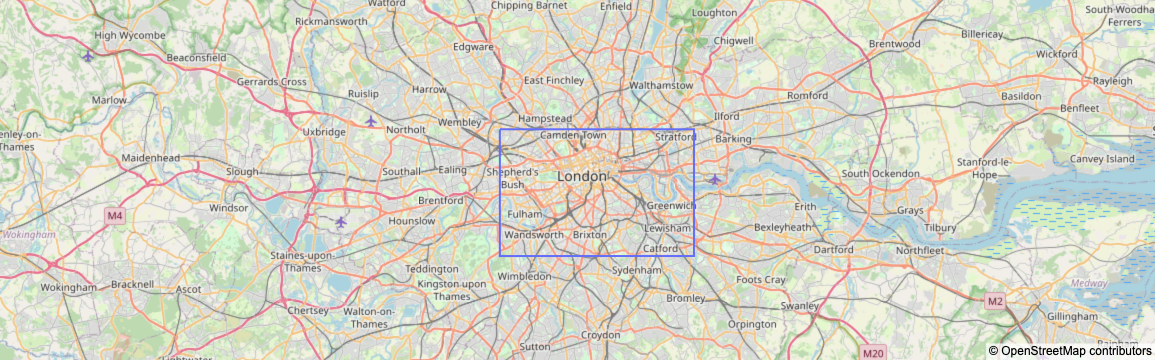

In [9]:
# Define search area via min and max latitude and longitude
min_lat = 51.438499 
max_lat = 51.546890
min_long = -0.240612
max_long = 0.026043

search_area_coords = [min_lat, max_lat, min_long, max_long]

plot_search_area(min_lat, max_lat, min_long, max_long)

### Setting Search Arguments

The venue search is defined and performed using the **perform_venue_search** function. This function takes multiple arguments which define how the search is performed. These arguments must all be provided and some require a certain amount of tuning to optimise the search (where optimisation means speeding up the search and minimising the number of API calls).  

The table below defines these arguments and provides advice on setting / tuning them: 

|Argument Name|Description|Setting / Tuning Advice|
|:---:|---|---|
|**search_area_coords**|List defining the search area via maximum and minimum latitude and longitude values.|This is set in the cell above, no special tuning is required, set based on where you want to search for venues.|
|**initial_search_radius**|The API is given a search location and a radius and returns up to 50 venues found within the provided radius of the search location. The Initial Search Radius is the first radius provided to the API whenever a new location is searched for venues. If 50 venues are returned, the radius is reduced and the API is called again until less than 50 venues are returned.<br><br>The Initial Search Radius will slowly reduce from the initial value it is set at. An update is printed to screen periodically. Whenever more than 60% of search locations (since the last update) require a smaller radius, the Initial Search Radius is Reduced and this is recorded in the next update. <br><br>If using multi-search, the Initial Search Radius is reset to the original value set by this argument each time the search of the area is re-run. |You want this to be as large as possible without reducing the Initial Search Radius on the first update. Around 2000 is a good starting point.|
|**time_between_updates**|Time period (in seconds) between printing updates to screen. This value is also the time period used to determine if the Initial Search Radius will be reduced.|You want fairly frequent updates so that the Initial Search Radius can be reduced optimally. We suggest you start with 20 seconds. Make sure you search at least 8 different search locations per update, otherwise you'll be deciding whether to reduce the Initial Search Radius on a small sample.|
|**cats**|Category filter - defines what category of venue you want the search to find e.g. bars only. Must be a comma separated string e.g. '11131,11039'. <br><br>If you do not want to filter venues by category, set as blank string ''|Find a list of category codes [here](https://location.foursquare.com/places/docs/categories).|
|**multi-search**|A single search of the entire geographic area typically returns ~90-95% of venues within the area. To get the final ~10% of venues, you need to re-run the search multiple times. The multi-search function will make the search re-run multiple times until the latest search does not find any new venues i.e. once ~100% of venues have been found.<br><br>Note - when using multi-search, you don't need to wait until the multi-search completely finishes. You can stop the code running anytime after at least 1 search has been completed and all venues found so far will be returned (you will not lose them).|Set as **False** if you do not want to use multi-search. <br>Set as **True** if you want to use multi-Search. Note that multi-search will significantly increase the run time and number of API calls. We suggest you switch off multi-search for your first run. Make sure the search completes correctly and tune the Initial Search Radius. Then you can switch on multi-search.|

### Example Tuned Searches
Below we provide 2 examples of search arguments we tuned for our computer. Both examples use the original geographic area defined in the above cell (London, England). We changed the categories being searched for, and this in turn changed the optimal Initial Search Radius: 

**Event Spaces In London** - *returns ~ 300 results, very fast to run*
- initial_search_radius = 1500
- cats = '11131,11039'
- time_between_updates = 20
- multi-search = False

**Bars and Restaurants in London** - *returns ~ 6000 results, 15 minutes to run*
- initial_search_radius = 1000
- cats = '10039,10040,10041,10045,10049,11039,13003'
- time_between_updates = 20
- multi-search = False

### Perform Venue Search
This is where we perform the venue search. Edit the search arguments (explained in the table above) then run the cell to perform the venue search: 

In [10]:
initial_search_radius = 1000
# The below commented out categories were used in testing. 
# They return event spaces only, and there are only around 
# 330 of them in the geographic area, so it makes a useful
# fast test search
#cats = '11131,11039'
cats = '10039,10040,10041,10045,10049,11039,13003'
time_between_updates = 20
multi_search = True

venues = perform_venue_search(search_area_coords, initial_search_radius, 
                            cats, time_between_updates, multi_search)


Total Venues Found -> 6701
Total Calls -> 6998

initial_search_radius = 1000
cats = '10039,10040,10041,10045,10049,11039,13003'
time_between_updates = 20
multi_search = True

Multi-Search Results:
Search 2: Found 166 new venues
Search 3: Found 7 new venues
Search 4: Found 1 new venues
Search 5: Found 5 new venues
Search 6: Found 3 new venues
Search 7: Found 0 new venues


### Preview Search Results 

In [11]:
venues.head()

fsq_id                  venue_name   latitude  longitude  \
0  5ae39a3fe7a237002ce39a87             The Walcot 1830  51.493178  -0.110544   
1  4fc20009e4b0e700fbf4c068  The Kennington Coffee Shop  51.492849  -0.110653   
2  4bfee23f4e5d0f47df4e7d1f                    The Ship  51.494076  -0.110822   
3  4b7744dbf964a520668d2ee3              The Kings Arms  51.489987  -0.108181   
4  5b1c38b735d3fc002ca5c960                The Oxymoron  51.492792  -0.111877   

                     address  postcode  
0          171 Kennington Rd  SE11 6SF  
1          173 Kennington Rd  SE11 6SR  
2          171 Kennington Rd  SE11 6SF  
3         98 Kennington Lane  SE11 4XD  
4  Royal Oak, 78 Fitzalan St  SE11 6QU

### Save Search Results

In [12]:
todays_date = datetime.today().strftime('%d-%b-%y')
venues.to_csv('foursquare_venues ' + todays_date + '.csv', index = False)

Uncomment the below code if you want to load the saved venues

In [6]:
#venues = pd.read_csv('foursquare_venues 15-Feb-23.csv')

### Price Calculation
The below calculates the cost for a certain number of Foursquare API calls. You can edit the **total_requests** variable and run the cell to estimate the total cost for that many API calls. 

In [13]:
total_requests = 11986
cost_per_request = 0.50
total_price_in_dollars = total_requests * cost_per_request / 100
print(f"Total price for {total_requests} requests is ${total_price_in_dollars}")

Total price for 11986 requests is $59.93


## Get Venue Details
We will now use the Foursquare API to pull extended venue data on each venue we found in the Venue Search. 
### Define API Call
We are using the [Get Place Details API](https://developer.foursquare.com/reference/place-details) to pull the extended venue data from Foursquare. This API takes the unique Foursquare ID for a venue and a list of data fields you want (e.g. 'price', 'popularity' etc.) and returns this data for the venue specified. See [here](https://developer.foursquare.com/reference/response-fields#core-data-fields) for detailed information on the all data fields that can be requested.

Below, we define a function to call the API and return its response. If you wish to change the data returned for each venue, you must edit the list that defines the **fields** parameter in the below function, using the field names found [here](https://developer.foursquare.com/reference/response-fields#core-data-fields). You will also need to update the **extract_venue_details** function (defined later) to extract any new data you add to the API response. 

In [2]:
# Base url of the Get Place Details API (requires the fsq_id of 
# the venue after 'places/' 
venue_details_url = "https://api.foursquare.com/v3/places/"

# RateLimiter decorator, ensures the api_call function is called less 
# than 50 times per second, the Foursquare rate limit
@RateLimiter(max_calls=49, period=1)
def get_venue_details(fsq_id, key):
    """Get venue details using foursquare Get Place Details API
    
    Note that the fsq_id is appended to the API url, it is not a 
    paramater of the html request.  
    
    Args:
        fsq_id (string): Foursquare ID for venue you are requesting details for
        key (string): Authorisation key (links request to account paying for request) 
    
    Returns: 
        Html response from Foursquare that contains extended data on the venue
    """
    # Fields paramater defines what data foursquare will return
    fields = ['location', 'categories', 'chains', 'related_places',
              'tel', 'fax', 'email', 'website', 'verified', 
              'hours_popular', 'rating', 'stats', 'popularity', 
              'price', 'date_closed', 'tastes']
    # Convert fields to comma separated list
    fields = ','.join(fields)
    params = dict(fields = fields)
    headers = {
        "Accept": "application/json",
        "Authorization": key
    }
    # fsq_id is appended to end of API request url
    return requests.request("GET", venue_details_url + fsq_id, 
                            headers = headers, params = params)

Below we perform a test to check the API request works. It should display a json containing data on the requested venue. 

In [10]:
# Perform Get Place Details API call
response = get_venue_details(venues.fsq_id[13], key)
# extract venue_details from response as json file
venue_details = json.loads(response.text)
# Visualise venue_details
JSON(venue_details)

<IPython.core.display.JSON object>

### Extract Data From API Response
Below we define functions to extract the data we want from the API response. Note that the API response is first converted to a json file. This file is then provided to the **extract_venue_details** function which extracts the data. 

The table below defines the data that is extracted from the json.

Data|Description
:---:|:---
email|contact email address of venue
tel|contact telephone number of venue
website|website of venue
verified|A boolean that indicates whether or not the FSQ Place has been claimed.
rating|A numerical rating (from 0.0 to 10.0) of the FSQ Place, based on user votes, likes/dislikes, tips sentiment, and visit data. Not all FSQ Places will have a rating.
popularity|Measure of the FSQ Place's popularity, by foot traffic. This score is on a 0 to 1 scale and uses a 6-month span of POI visits for a given geographic area.
price|A numerical value (from 1 to 4) that best describes the pricing tier of the FSQ Place, based on known prices for menu items and other offerings. Values include: 1 = Cheap, 2 = Moderate, 3 = Expensive, and 4 = Very Expensive
date_closed|The recorded date when the FSQ Place was marked as permanently closed in Foursquare's databases. This does not necessarily indicate the POI was actually closed on this date.
categories|An array, possibly empty, of categories that describe the FSQ Place. Stored as a list of strings. 
total_ratings|Total number of ratings for venue 
parent|If the venue is owned by a parent venue, the parent venue's name will be listed 
parent_fsq_id|If the venue is owned by a parent venue, the parent venue's foursquare ID will be listed 
neighborhood|Description of the neighborhood the venue is located in e.g. 'Clapham'. When initially extracted it is stored as a one item list.

In [11]:
def extract_venue_details(venue_details):
    """Extract data from venue_details json as a list
    
    Args:
        venue_details (json): The json file containing the venue details data.
        
    Returns:
        list: The data for the venue, e.g. 'email', 'price' etc. in a single 
            list. All data that couldnt be found is nan."""
    fields = venue_details.keys() 
    # Extract simple data from venue_details json
    email = extract_simple_data('email', venue_details, fields)
    tel = extract_simple_data('tel', venue_details, fields)
    website = extract_simple_data('website', venue_details, fields)
    verified = extract_simple_data('verified', venue_details, fields)
    rating = extract_simple_data('rating', venue_details, fields)
    popularity = extract_simple_data('popularity', venue_details, fields)
    price = extract_simple_data('price', venue_details, fields)
    date_closed = extract_simple_data('date_closed', venue_details, fields)

    # total_ratings is stored under 'stats' within the venue_details json. Below 
    # we extract the 'stats' dict from venue_details json and then extract 
    # total_ratings from that.  
    stats = extract_simple_data('stats', venue_details, fields)
    # Check stats wasn't nan
    if stats == stats:
        total_ratings = stats['total_ratings']
    else: 
        total_ratings = np.nan

    # Extract categories as a list of possible categories. If categories not
    # in json, return nan. 
    if 'categories' in fields:
        # Categories stored as a list in the venue_details json
        categories_list = venue_details['categories']
        categories = []
        # Loop through categories_list and extract the string name of each
        # category in the list. 
        for category in categories_list:
            categories.append(category['name'])        
    else:
        categories = np.nan

    # Extract parent from 'related_places' field. 'related_places' always
    # exists but contains an empty dictionary most of the time. We only 
    # want to extract the parent data if the parent field exists within 
    # the 'related_places' dictionary. 
    related_places = venue_details['related_places']
    # Check if 'related_places' dic contains something
    if len(related_places) > 0:
        # Check if 'parent' contained within 'related_places'
        if 'parent' in related_places.keys():
            parent = related_places['parent']['name']
            parent_fsq_id = related_places['parent']['fsq_id']
        else: 
            parent = np.nan
            parent_fsq_id = np.nan
    else: 
        parent = np.nan
        parent_fsq_id = np.nan

    # Extract 'neighborhood' from the 'location' field. 'location' stores 
    # data as a dict.
    location_fields = venue_details['location'].keys()
    # Can repurpose the 'extract_simple_data' function to extract
    # 'neighborhood' data from the 'location' dictionary. 
    locality = extract_simple_data('locality', 
                                       venue_details['location'], 
                                       location_fields)

    return [email, tel, website, verified, rating, popularity, price, 
           date_closed, categories, total_ratings, parent, 
           parent_fsq_id, locality]

def extract_simple_data(field, venue_details, fields):
    """Extracts data from venue_details json using the associated field
    
    Args:
        field (str): The field you wish to extract the value of e.g. 'email'.
        venue_details (json): The json file containing the data.
        fields (list): All fields contained by the json file. 

    Returns:
        bool/str/float/dict/np.nan: Returns the data stored in venue_details json 
            under the provided field. If the provided field does not exist in 
            the venue_details json, returns np.nan. 
    """
    if field in fields:
        return venue_details[field]
    else:
        return np.nan

### Get Venue Details
Below we request and extract extended data for every venue we found. It takes roughly 35 minutes to run the code and cost ~ $60 for around 6000 venues.

In [12]:
venue_details_data = []
total_venues = venues.shape[0]
# Loop through venue foursquare ids (fsq_id), request venue details from
# API and extract required data
for index, fsq_id in enumerate(venues.fsq_id):
    # Perform Get Place Details API call
    response = get_venue_details(fsq_id, key)
    # Keep retrying API call every 5 seconds if the API response code
    # indicates an error (i.e. not 200) 
    while response.status_code != 200:
            print(f"API Error code {response.status_code}, sleeping 5 seconds")
            time.sleep(5)
            # retry API call
            response = get_venue_details(fsq_id, key)
    # extract venue_details from response as json file
    venue_details = json.loads(response.text)
    # Extract data from venue_details json and append to list
    extracted_data = extract_venue_details(venue_details)
    # Add fsq_id to first entry of extracted_data list
    extracted_data = [fsq_id] + extracted_data
    venue_details_data.append(extracted_data)
    #print(index)
    # Provide status update every time 500 venues details have been extracted
    if (index + 1) % 500 == 0:
        print(f"{index + 1} venue details extracted out of {total_venues}")

500 venue details extracted out of 6701
1000 venue details extracted out of 6701
1500 venue details extracted out of 6701
2000 venue details extracted out of 6701
2500 venue details extracted out of 6701
3000 venue details extracted out of 6701
3500 venue details extracted out of 6701
4000 venue details extracted out of 6701
4500 venue details extracted out of 6701
5000 venue details extracted out of 6701
5500 venue details extracted out of 6701
6000 venue details extracted out of 6701
6500 venue details extracted out of 6701


## Clean And Save Data
### Build Dataframe
We need to clean and restructure parts of the venue details data. Below, we create a dataframe with the venue details data.

In [37]:
venue_details_df = pd.DataFrame(venue_details_data, 
                             columns = ['fsq_id', 'email', 'tel', 'website', 'verified', 
                                        'rating', 'popularity', 'price', 
                                        'date_closed', 'categories', 
                                        'total_ratings', 'parent', 
                                        'parent_fsq_id', 'locality'])

### Save Data
Save data in case of any issues / to avoid having to re-request all the venue details. 

In [38]:
todays_date = datetime.today().strftime('%d-%b-%y')
venue_details_df.to_csv('venue_details_' + todays_date + '.csv',
                        index = False)

Optional code - used to load the saved venue details data if you need to. 

In [39]:
# Load in saved raw venue details data if required 
#from ast import literal_eval
#venue_details_df = pd.read_csv('venue_details.csv', converters={"categories": literal_eval})

In [40]:
venue_details_df.head()

fsq_id                       email            tel  \
0  5ae39a3fe7a237002ce39a87                         NaN  020 7735 1371   
1  4fc20009e4b0e700fbf4c068                         NaN  020 7735 1371   
2  4bfee23f4e5d0f47df4e7d1f  theship@frontierpubs.co.uk  020 7735 1371   
3  4b7744dbf964a520668d2ee3                         NaN  020 7735 2039   
4  5b1c38b735d3fc002ca5c960                         NaN   07515 878976   

                                             website  verified  rating  \
0                      http://www.thewalcot1830.com/     False     NaN   
1                       http://www.theshiplondon.com     False     6.9   
2  https://www.frontierpubs.co.uk/your-local/the-...     False     7.6   
3  https://whatpub.com/pubs/SEL/10623/king-s-arms...     False     7.4   
4                      http://www.oxymoronse11.co.uk     False     NaN   

   popularity  price  date_closed                     categories  \
0    0.578290    1.0          NaN              [Pub, Restaurant]   
1    0.969674    1.0          NaN  [Bar, Coffee Shop, Gastropub]   
2    0.955074    1.0          NaN                          [Bar]   
3    0.947250    1.0          NaN                          [Pub]   
4    0.361463    1.0          NaN                [Beer Bar, Pub]   

   total_ratings parent parent_fsq_id locality  
0            NaN    NaN           NaN   London  
1           19.0    NaN           NaN   London  
2           67.0    NaN           NaN   London  
3           12.0    NaN           NaN   London  
4            NaN    NaN           NaN   London

### Expand 'Categories' Column

Foursquare categorises venues using category such as 'Bar', 'Restaurant' etc. Every venue can be assigned up to 3 categories. There are hundreds of possible categories. The 'categories' column contains a list with the categories each venue is assigned to e.g. \[Arts and Entertainment, Pub, English Restaurant]. 

Because any venue can have any combination of up to 3 categories, there is no simple way (e.g. a single column) of representing this data. The simplest way is to One Hot Encode the data i.e. create a new column for each possible category and assign it a 1 or 0 depending on whether the venue has that category.  

Below we one hot encode the 'categories' column (as a new dataframe) and summarise how common each category is. 

In [41]:
# Dummy variable the lists in the 'categories' column such that a new 
# column is made for each category named in the lists and it will 
# have a 0 or a 1 depending on whether that category was included 
# in the list for that row.   
categories_df = venue_details_df['categories'].str.join('|').str.get_dummies()
# Expand pandas viewing options so full series can be printed 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# Sum up each category and sort descending to see which 
# categories are most common 
categories_sum = categories_df.sum().sort_values(ascending = False)
categories_sum

Bar                                2298
Restaurant                         1630
Pub                                1263
Cocktail Bar                        774
Wine Bar                            766
Music Venue                         645
Arts and Entertainment              372
Gastropub                           307
Event Space                         290
Lounge                              283
Night Club                          278
Concert Hall                        239
Beer Bar                            234
Hotel Bar                           207
English Restaurant                  157
Theater                             152
Sports Bar                          126
Italian Restaurant                   98
Café                                 88
Beer Garden                          81
American Restaurant                  81
Gay Bar                              73
Modern European Restaurant           69
Coffee Shop                          68
Pizzeria                             65


We have hundreds of available categories, and since each has a separate column this leads to column explosion. We decided to only take the top 10 most common categories and drop the rest. This is done below. 

Note - another option is to map the lower level categories e.g. 'Spanish Restaurant' to a higher level category e.g. 'Restaurant'. This seems like a useful way to reduce the categories without losing much information. We decided to keep it simple for now and just take the top 10. 

In [42]:
# Select the top 10 most common categories
top_10_categories = categories_sum.nlargest(10).index.values
# Add these categories to the venue_details_df
venue_details_df = pd.concat([venue_details_df, 
                              categories_df[top_10_categories]], 
                             axis = 1)
# Drop 'categories' column (optional, we chose to keep this)
#venue_details_df.drop(['categories'], inplace = True, axis = 1)

In [43]:
venue_details_df.head()

fsq_id                       email            tel  \
0  5ae39a3fe7a237002ce39a87                         NaN  020 7735 1371   
1  4fc20009e4b0e700fbf4c068                         NaN  020 7735 1371   
2  4bfee23f4e5d0f47df4e7d1f  theship@frontierpubs.co.uk  020 7735 1371   
3  4b7744dbf964a520668d2ee3                         NaN  020 7735 2039   
4  5b1c38b735d3fc002ca5c960                         NaN   07515 878976   

                                             website  verified  rating  \
0                      http://www.thewalcot1830.com/     False     NaN   
1                       http://www.theshiplondon.com     False     6.9   
2  https://www.frontierpubs.co.uk/your-local/the-...     False     7.6   
3  https://whatpub.com/pubs/SEL/10623/king-s-arms...     False     7.4   
4                      http://www.oxymoronse11.co.uk     False     NaN   

   popularity  price  date_closed                     categories  \
0    0.578290    1.0          NaN              [Pub, Restaurant]   
1    0.969674    1.0          NaN  [Bar, Coffee Shop, Gastropub]   
2    0.955074    1.0          NaN                          [Bar]   
3    0.947250    1.0          NaN                          [Pub]   
4    0.361463    1.0          NaN                [Beer Bar, Pub]   

   total_ratings parent parent_fsq_id locality  Bar  Restaurant  Pub  \
0            NaN    NaN           NaN   London    0           1    1   
1           19.0    NaN           NaN   London    1           0    0   
2           67.0    NaN           NaN   London    1           0    0   
3           12.0    NaN           NaN   London    0           0    1   
4            NaN    NaN           NaN   London    0           0    1   

   Cocktail Bar  Wine Bar  Music Venue  Arts and Entertainment  Gastropub  \
0             0         0            0                       0          0   
1             0         0            0                       0          1   
2             0         0            0                       0          0   
3             0         0            0                       0          0   
4             0         0            0                       0          0   

   Event Space  Lounge  
0            0       0  
1            0       0  
2            0       0  
3            0       0  
4            0       0

### Percentage of Values Present (Not Missing)
Below we show the percentage of values that are present (**NOT** missing) per column:

In [44]:
#total_venues = venues.shape[0]
# Percentage of values not missing in each column
venue_details_df.notnull().sum() * 100 / total_venues 

fsq_id                    100.000000
email                      16.788539
tel                        78.540516
website                    70.482018
verified                  100.000000
rating                     40.516341
popularity                 72.078794
price                      59.931354
date_closed                 0.000000
categories                100.000000
total_ratings              40.516341
parent                     11.595284
parent_fsq_id              11.595284
locality                   93.209969
Bar                       100.000000
Restaurant                100.000000
Pub                       100.000000
Cocktail Bar              100.000000
Wine Bar                  100.000000
Music Venue               100.000000
Arts and Entertainment    100.000000
Gastropub                 100.000000
Event Space               100.000000
Lounge                    100.000000
dtype: float64

### Merge Extended Dataframe Data with Venue Search Data
Below we merge the data from the venue search with the data from the extended data collection: 

In [45]:
# Merge venues df with venue_details df
full_venue_data = pd.merge(venues, venue_details_df, how="left", on='fsq_id', 
                           sort=False, copy=True, validate='one_to_one')
full_venue_data.head()

fsq_id                  venue_name   latitude  longitude  \
0  5ae39a3fe7a237002ce39a87             The Walcot 1830  51.493178  -0.110544   
1  4fc20009e4b0e700fbf4c068  The Kennington Coffee Shop  51.492849  -0.110653   
2  4bfee23f4e5d0f47df4e7d1f                    The Ship  51.494076  -0.110822   
3  4b7744dbf964a520668d2ee3              The Kings Arms  51.489987  -0.108181   
4  5b1c38b735d3fc002ca5c960                The Oxymoron  51.492792  -0.111877   

                     address  postcode                       email  \
0          171 Kennington Rd  SE11 6SF                         NaN   
1          173 Kennington Rd  SE11 6SR                         NaN   
2          171 Kennington Rd  SE11 6SF  theship@frontierpubs.co.uk   
3         98 Kennington Lane  SE11 4XD                         NaN   
4  Royal Oak, 78 Fitzalan St  SE11 6QU                         NaN   

             tel                                            website  verified  \
0  020 7735 1371                      http://www.thewalcot1830.com/     False   
1  020 7735 1371                       http://www.theshiplondon.com     False   
2  020 7735 1371  https://www.frontierpubs.co.uk/your-local/the-...     False   
3  020 7735 2039  https://whatpub.com/pubs/SEL/10623/king-s-arms...     False   
4   07515 878976                      http://www.oxymoronse11.co.uk     False   

   rating  popularity  price  date_closed                     categories  \
0     NaN    0.578290    1.0          NaN              [Pub, Restaurant]   
1     6.9    0.969674    1.0          NaN  [Bar, Coffee Shop, Gastropub]   
2     7.6    0.955074    1.0          NaN                          [Bar]   
3     7.4    0.947250    1.0          NaN                          [Pub]   
4     NaN    0.361463    1.0          NaN                [Beer Bar, Pub]   

   total_ratings parent parent_fsq_id locality  Bar  Restaurant  Pub  \
0            NaN    NaN           NaN   London    0           1    1   
1           19.0    NaN           NaN   London    1           0    0   
2           67.0    NaN           NaN   London    1           0    0   
3           12.0    NaN           NaN   London    0           0    1   
4            NaN    NaN           NaN   London    0           0    1   

   Cocktail Bar  Wine Bar  Music Venue  Arts and Entertainment  Gastropub  \
0             0         0            0                       0          0   
1             0         0            0                       0          1   
2             0         0            0                       0          0   
3             0         0            0                       0          0   
4             0         0            0                       0          0   

   Event Space  Lounge  
0            0       0  
1            0       0  
2            0       0  
3            0       0  
4            0       0

In [46]:
# Move total_ratings and neighborhood columns
full_venue_data.insert(12, 'total_ratings', 
                       full_venue_data.pop('total_ratings'))
full_venue_data.insert(4, 'locality', 
                       full_venue_data.pop('locality'))
full_venue_data.head()

fsq_id                  venue_name   latitude  longitude  \
0  5ae39a3fe7a237002ce39a87             The Walcot 1830  51.493178  -0.110544   
1  4fc20009e4b0e700fbf4c068  The Kennington Coffee Shop  51.492849  -0.110653   
2  4bfee23f4e5d0f47df4e7d1f                    The Ship  51.494076  -0.110822   
3  4b7744dbf964a520668d2ee3              The Kings Arms  51.489987  -0.108181   
4  5b1c38b735d3fc002ca5c960                The Oxymoron  51.492792  -0.111877   

  locality                    address  postcode                       email  \
0   London          171 Kennington Rd  SE11 6SF                         NaN   
1   London          173 Kennington Rd  SE11 6SR                         NaN   
2   London          171 Kennington Rd  SE11 6SF  theship@frontierpubs.co.uk   
3   London         98 Kennington Lane  SE11 4XD                         NaN   
4   London  Royal Oak, 78 Fitzalan St  SE11 6QU                         NaN   

             tel                                            website  verified  \
0  020 7735 1371                      http://www.thewalcot1830.com/     False   
1  020 7735 1371                       http://www.theshiplondon.com     False   
2  020 7735 1371  https://www.frontierpubs.co.uk/your-local/the-...     False   
3  020 7735 2039  https://whatpub.com/pubs/SEL/10623/king-s-arms...     False   
4   07515 878976                      http://www.oxymoronse11.co.uk     False   

   rating  popularity  total_ratings  price  date_closed  \
0     NaN    0.578290            NaN    1.0          NaN   
1     6.9    0.969674           19.0    1.0          NaN   
2     7.6    0.955074           67.0    1.0          NaN   
3     7.4    0.947250           12.0    1.0          NaN   
4     NaN    0.361463            NaN    1.0          NaN   

                      categories parent parent_fsq_id  Bar  Restaurant  Pub  \
0              [Pub, Restaurant]    NaN           NaN    0           1    1   
1  [Bar, Coffee Shop, Gastropub]    NaN           NaN    1           0    0   
2                          [Bar]    NaN           NaN    1           0    0   
3                          [Pub]    NaN           NaN    0           0    1   
4                [Beer Bar, Pub]    NaN           NaN    0           0    1   

   Cocktail Bar  Wine Bar  Music Venue  Arts and Entertainment  Gastropub  \
0             0         0            0                       0          0   
1             0         0            0                       0          1   
2             0         0            0                       0          0   
3             0         0            0                       0          0   
4             0         0            0                       0          0   

   Event Space  Lounge  
0            0       0  
1            0       0  
2            0       0  
3            0       0  
4            0       0

### Save Final Data

In [47]:
todays_date = datetime.today().strftime('%d-%b-%y')
full_venue_data.to_csv('foursquare_full_venue_data_' + todays_date + '.csv',
                       index = False)